#Predictive Linear Modeling

Now that we've seen how are basic outcomes and predictors behave, we can start to see if we can model them using some basic linear models. At this point, it makes most sense to characterize each pollutant as their own regression as we see that they all act differently in the exploratory data analysis. We will just throw in all predictors first. This isn't the most principled approach as we may want to do some variable selection, but it may be a good starting point before moving into more sophisticated models to get a sense of the various factors that are important to each pollutant.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

In [2]:
#Load in the 3 US datasets
YearDat = pd.read_csv('YearDat2.csv')
MonthDat = pd.read_csv('MonthDat2.csv')
SeasonDat = pd.read_csv('SeasonDat2.csv')

##Basic Multivariate Linear Regression

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

In [4]:
#Make a predictor for cars in general -- pooling alone and carpooling
YearDat['car_frac'] = YearDat['carpool_frac']+YearDat['alone_frac']
YearDat['car'] = YearDat['carpool'] + YearDat['alone']

In [5]:
#Make a predictor of PT and Other (walk or bike) as these are
#things that have less emission
YearDat['pt_other_frac'] = YearDat['pt_frac']+YearDat['other_frac']
YearDat['pt_other'] = YearDat['pt']+YearDat['other']

In [6]:
#Make a dataframe for each pollutant, this makes it easier
#to deal with missing values later on by removing them here
#In general, if we don't have pollutant data, there's really
#nothing we can do beyond imputing...given that we seem to have
#good coverage of the US still and values seem to be missing mostly
#at random, dropping those observations should be okay
no2US_y = YearDat[pd.notnull(YearDat['NO2'])]
coUS_y = YearDat[pd.notnull(YearDat['CO'])]
so2US_y = YearDat[pd.notnull(YearDat['SO2'])]
ozoneUS_y = YearDat[pd.notnull(YearDat['OZONE'])]
pm25US_y = YearDat[pd.notnull(YearDat['PM25_FRMFEM'])]
pm10US_y = YearDat[pd.notnull(YearDat['PM10'])]

In [7]:
#Fit each model for each pollutant
#Only using one of the transportation mode variables to avoid multicollinearity
no2_model_y = ols('NO2 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip',no2US_y).fit()
co_model_y = ols('CO ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip',coUS_y).fit()
so2_model_y = ols('SO2 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip',so2US_y).fit()
ozone_model_y = ols('OZONE ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip',ozoneUS_y).fit()
pm25_model_y = ols('PM25_FRMFEM ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip',pm25US_y).fit()
pm10_model_y = ols('PM10 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip',pm10US_y).fit()

C:\Users\Mark\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


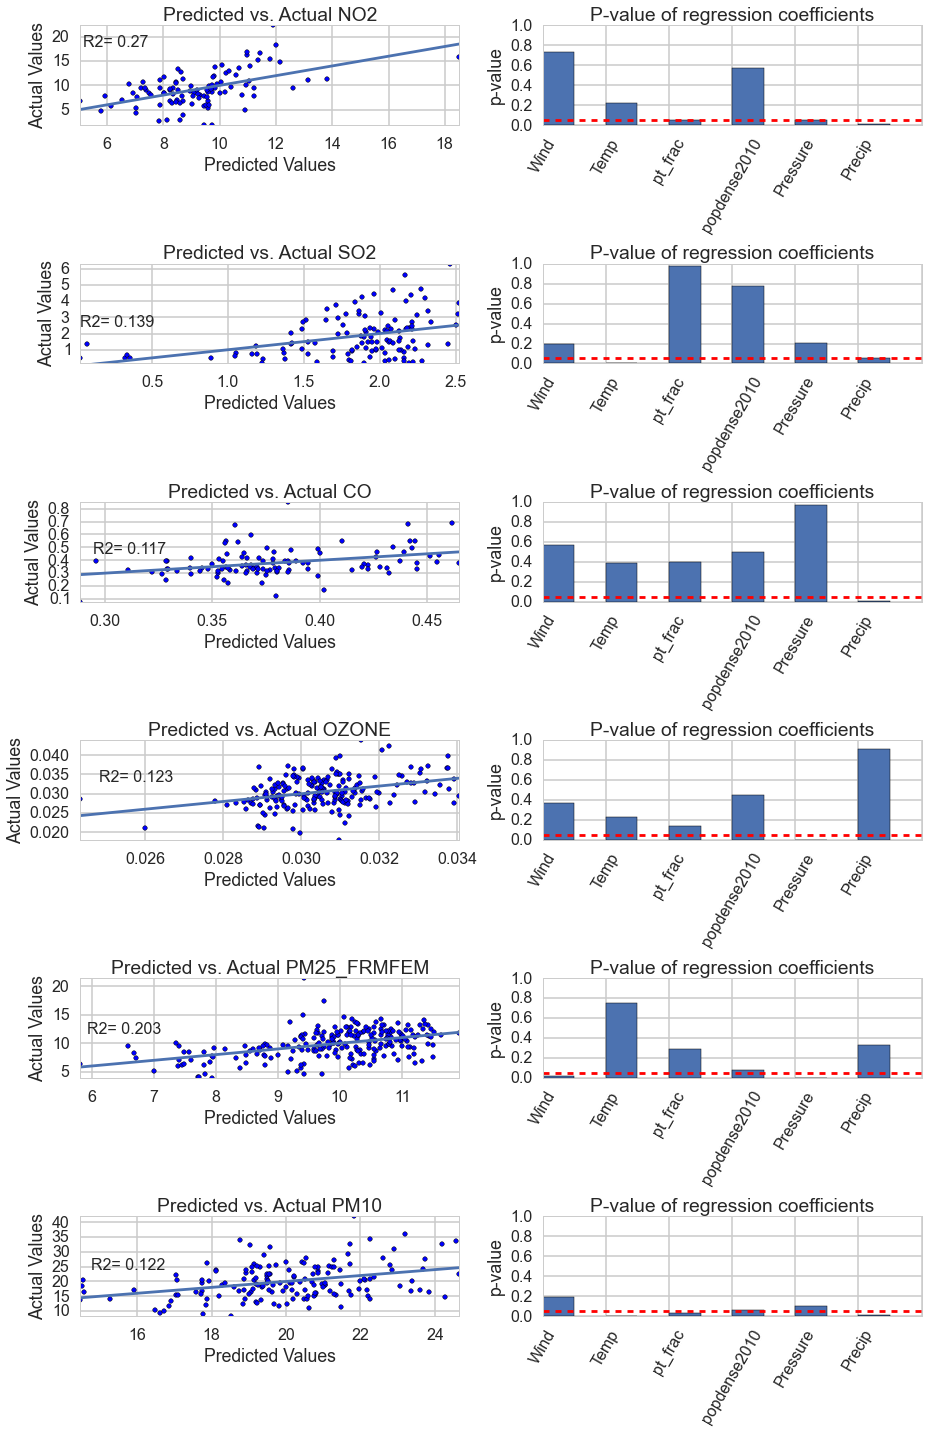

In [8]:
#Make a visualization of each regresion
#Go through each model storing each model in a list twice
models_to_loop=[('NO2',no2_model_y,no2US_y),('NO2',no2_model_y,no2US_y),('SO2',so2_model_y,so2US_y),('SO2',so2_model_y,so2US_y),
                ('CO',co_model_y,coUS_y),('CO',co_model_y,coUS_y),('OZONE',ozone_model_y,ozoneUS_y),('OZONE',ozone_model_y,ozoneUS_y),
                ('PM25_FRMFEM',pm25_model_y,pm25US_y),('PM25_FRMFEM',pm25_model_y,pm25US_y),('PM10',pm10_model_y,pm10US_y),('PM10',pm10_model_y,pm10US_y)]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 20))
fig.set_tight_layout(True)

#Plot a fitted vs. predicted plot for each model
#along with bar graphs for their p-values to indicate
#which predictors are significantly related to the pollutant
count = 0
for ax,j in zip(axes.ravel(),models_to_loop):
    count += 1
    if count % 2 != 0:
        ax.scatter(j[1].predict(),j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]])
        ax.plot([0,25], [0,25])
        ax.set_ylim((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).min(),(j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).max())
        ax.set_xlim(j[1].predict().min(),j[1].predict().max())
        ax.set_ylabel('Actual Values')
        ax.set_xlabel('Predicted Values')
        ax.annotate('R2= '+str(round(j[1].rsquared,3)),xy=(j[1].predict().min()*1.02,j[1].predict().max()*.98),xytext=(j[1].predict().min()*1.02,j[1].predict().max()*.98),fontsize=16)
        ax.set_title('Predicted vs. Actual '+j[0])
    else:
        ax.bar([0,1,2,3,4,5],(sp.stats.t.sf(np.abs(j[1].tvalues), j[1].nobs-1)*2)[1:],.5)
        ax.set_ylim(0,1)
        ax.set_xticklabels(list(j[1].params.index)[1:],rotation=60,ha='center')
        ax.set_ylabel('p-value')
        ax.set_title('P-value of regression coefficients')
        ax.axhline(0.05,color='red',ls='--')

In general, these simple models don't fit perfectly, but we do get at least some fitting. The $R^2$ values range from 0.12 to 0.27 with the best $R^2$ for $NO_2$. Perhaps more interesting are the particular predictors that are significantly associated with each pollutant, controlling for the other predictors. Interpretting these coefficients should be done with caution and we wouldn't want to report out any of the significant relationships from this model without first checking all assumptions. However, for now we're just trying to get a sense of how to develop the strongest predictive model so we can ignore assumptions and just try to get an overall picture.

Average yearly wind is only a significant predictor for PM2.5, which makes some sense as this is small particulate matter and more likely to be influenced by wind than gases or larger particulates. Average yearly temperature seems to be significantly related to average yearly PM10 and $SO_2$. Average yearly air pressure is significantly related to PM2.5, ozone, and borderline for $NO_2$. Ozone and air pressure have a known relationship -- ozone increases with atmospheric pressure (lower elevation) (http://www.ucar.edu/communications/gcip/m1sod/m1pdfc1.pdf) so that makes sense. Precipiation is significant to PM10, CO, $NO_2$, and $SO_2$. PM10 is large particulate matter so one could imagine how rain may wash some of that out of the air more than gases or small particulates. The relationship between $SO_2$ and precipitation may be a result of acid rain increasing atmospheric concentration. In general, rain may be a natural way to clear pollutants from the air as we see it's significant relationship with many of the pollutants.

In terms of anthropogenic features, the fraction of individuals who commute via public transit only appears significant for PM10 and $NO_2$. It's interesting to see the impact it may have on exhaust emissions as well as paritculate matter. Population density is not significantly related to the pollutants in the context of the other variables, although it is borderline significant for the particulate matter which may not be surpising.

##Incorporating seasonal variation

We know the previous model is a bit naive given what we know about seasonal variation in pollutants and weather. Therefore it makes some sense to try to incorporate seasonality into the model in some form or another so that we aren't just looking at overall yearly averages. We can do this first by just adding an indicator for season into the six models. Of course, when we do this, we now have 4 observations from each site (one from each season) so our Y's may be correlated. This could potentially be an issue and we would likely want to build a more sophisticated model, but it's worth just seeing how our regressions change before making that assessment.

In [9]:
#Make a predictor for cars in general -- pooling alone and carpooling
SeasonDat['car_frac'] = SeasonDat['carpool_frac']+SeasonDat['alone_frac']
SeasonDat['car'] = SeasonDat['carpool'] + SeasonDat['alone']

In [10]:
#Make a predictor of PT and Other (walk or bike) as these are
#things that have less emission
SeasonDat['pt_other_frac'] = SeasonDat['pt_frac']+SeasonDat['other_frac']
SeasonDat['pt_other'] = SeasonDat['pt']+SeasonDat['other']

In [11]:
#Make a dataframe for each pollutant, this makes it easier
#to deal with missing values later on
no2US_s = SeasonDat[pd.notnull(SeasonDat['NO2'])]
coUS_s = SeasonDat[pd.notnull(SeasonDat['CO'])]
so2US_s = SeasonDat[pd.notnull(SeasonDat['SO2'])]
ozoneUS_s = SeasonDat[pd.notnull(SeasonDat['OZONE'])]
pm25US_s = SeasonDat[pd.notnull(SeasonDat['PM25_FRMFEM'])]
pm10US_s = SeasonDat[pd.notnull(SeasonDat['PM10'])]

In [12]:
#Fit all the models
no2_model_s = ols('NO2 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+season',no2US_s).fit()
co_model_s = ols('CO ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+season',coUS_s).fit()
so2_model_s = ols('SO2 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+season',so2US_s).fit()
ozone_model_s = ols('OZONE ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+season',ozoneUS_s).fit()
pm25_model_s = ols('PM25_FRMFEM ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+season',pm25US_s).fit()
pm10_model_s= ols('PM10 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+season',pm10US_s).fit()

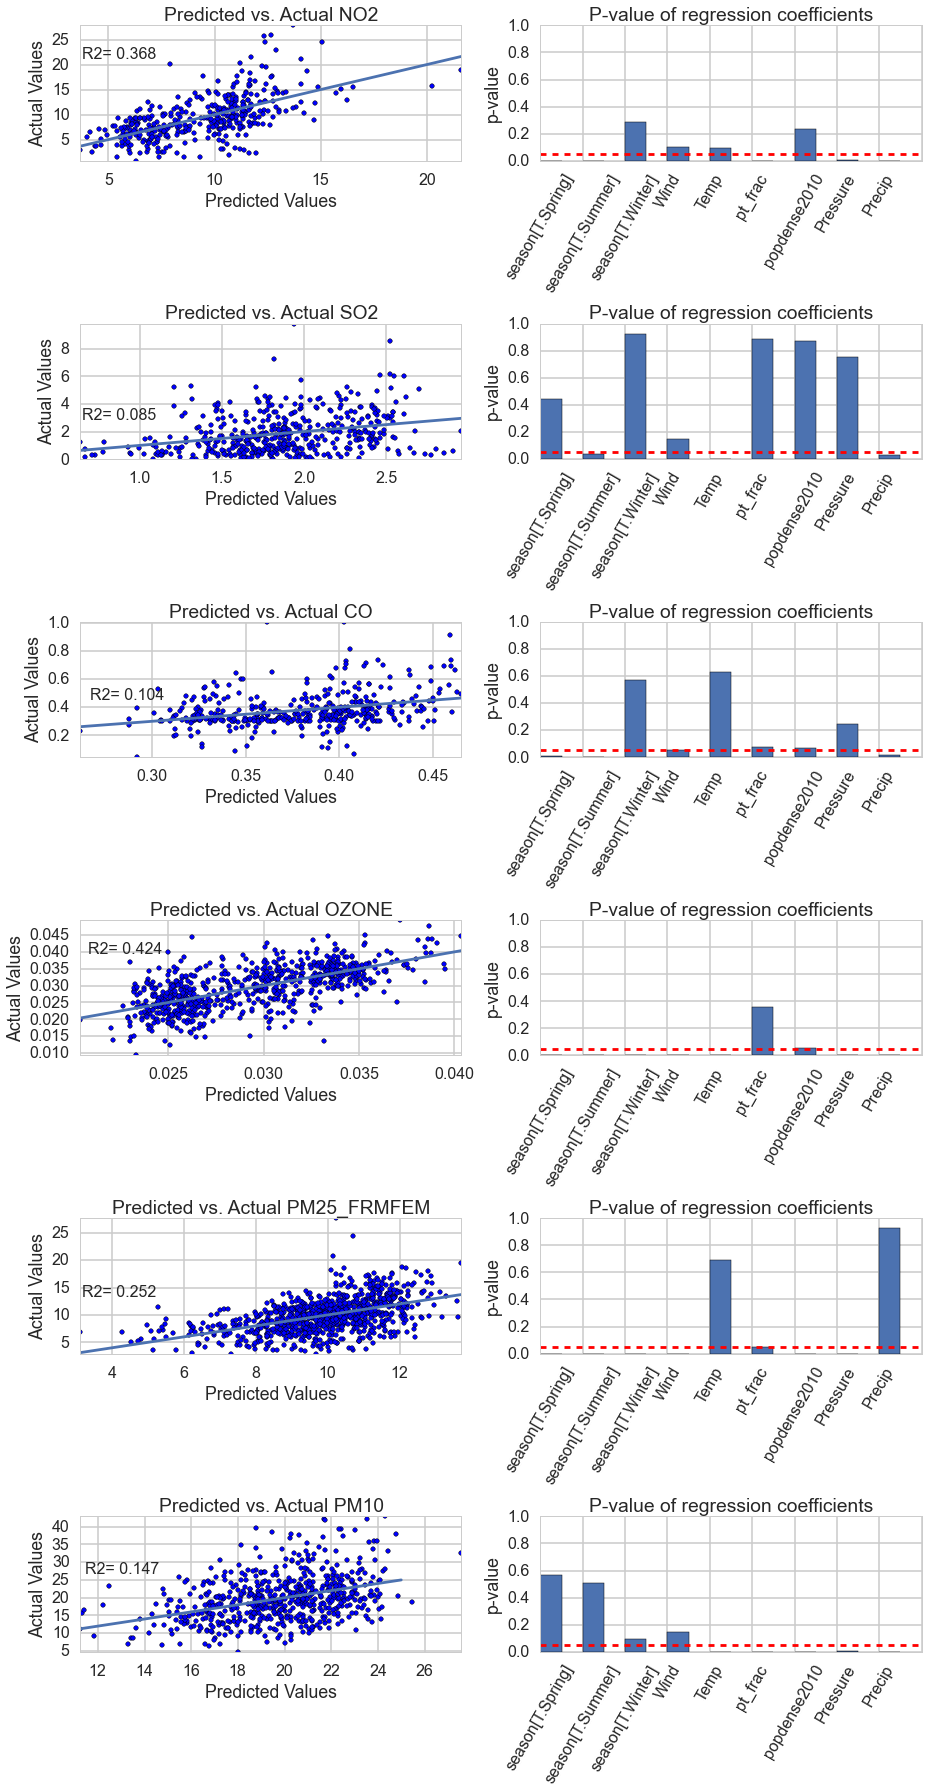

In [13]:
#Same as the yearly code to make images
rmse_allpred = {}
models_to_loop=[('NO2',no2_model_s,no2US_s),('NO2',no2_model_s,no2US_s),('SO2',so2_model_s,so2US_s),('SO2',so2_model_s,so2US_s),
                ('CO',co_model_s,coUS_s),('CO',co_model_s,coUS_s),('OZONE',ozone_model_s,ozoneUS_s),('OZONE',ozone_model_s,ozoneUS_s),
                ('PM25_FRMFEM',pm25_model_s,pm25US_s),('PM25_FRMFEM',pm25_model_s,pm25US_s),('PM10',pm10_model_s,pm10US_s),('PM10',pm10_model_s,pm10US_s)]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 25))
fig.set_tight_layout(True)

count = 0
for ax,j in zip(axes.ravel(),models_to_loop):
    count += 1
    if count % 2 != 0:
        ax.scatter(j[1].predict(),j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]])
        ax.plot([0,25], [0,25])
        ax.set_ylim((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).min(),(j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).max())
        ax.set_xlim(j[1].predict().min(),j[1].predict().max())
        ax.set_ylabel('Actual Values')
        ax.set_xlabel('Predicted Values')
        ax.annotate('R2= '+str(round(j[1].rsquared,3)),xy=(j[1].predict().min()*1.02,j[1].predict().max()*.98),xytext=(j[1].predict().min()*1.02,j[1].predict().max()*.98),fontsize=16)
        ax.set_title('Predicted vs. Actual '+j[0])
    else:
        ax.bar([0,1,2,3,4,5,6,7,8],(sp.stats.t.sf(np.abs(j[1].tvalues), j[1].nobs-1)*2)[1:],.5)
        ax.set_ylim(0,1)
        ax.set_xticklabels(list(j[1].params.index)[1:],rotation=60,ha='center')
        ax.set_ylabel('p-value')
        ax.set_title('P-value of regression coefficients')
        ax.axhline(0.05,color='red',ls='--')
    rmse_allpred[j[0]]=np.mean((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]] - j[1].predict()) ** 2)

In general, this improved the model for many pollutants, but not all, as evidenced by the increase in $R^2$. $Ozone$, $NO_2$, and $PM2.5$ saw the greatest improvement in $R^2$ which isn't surprisingly given that they seemed to have more seasonal variation than the other pollutants in our exploratory data analysis. The predictors relevant to each model have changed now that we are controlling for seasonal variation. In the future, it seems that incorporating season into the model will be beneficial.

##Incorporating Monthly Variation

We can increase our granularity of yearly changes in predictors by looking at monthly data. This involves creating 11 dummy variables. Again, it may not be the most principled approach as we are likely introducing autocorrelation in the pollutant levels, but will give us an idea of whether a monthly model is worth pursuing.

In [14]:
#Make a predictor for cars in general -- pooling alone and carpooling
MonthDat['car_frac'] = MonthDat['carpool_frac']+MonthDat['alone_frac']

In [15]:
#Make a predictor of PT and Other (walk or bike) as these are
#things that have less emission
MonthDat['pt_other_frac'] = MonthDat['pt_frac']+MonthDat['other_frac']

In [16]:
MonthDat['month_c']=MonthDat['month'].astype('str')

In [17]:
#Make a dataframe for each pollutant, this makes it easier
#to deal with missing values later on
no2US_m = MonthDat[pd.notnull(MonthDat['NO2'])]
coUS_m = MonthDat[pd.notnull(MonthDat['CO'])]
so2US_m = MonthDat[pd.notnull(MonthDat['SO2'])]
ozoneUS_m = MonthDat[pd.notnull(MonthDat['OZONE'])]
pm25US_m = MonthDat[pd.notnull(MonthDat['PM25_FRMFEM'])]
pm10US_m = MonthDat[pd.notnull(MonthDat['PM10'])]

In [18]:
#Fit the monthly models
no2_model_m = ols('NO2 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+month_c',no2US_m).fit()
co_model_m = ols('CO ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+month_c',coUS_m).fit()
so2_model_m = ols('SO2 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+month_c',so2US_m).fit()
ozone_model_m = ols('OZONE ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+month_c',ozoneUS_m).fit()
pm25_model_m = ols('PM25_FRMFEM ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+month_c',pm25US_m).fit()
pm10_model_m = ols('PM10 ~ Wind + Temp + pt_frac + popdense2010 + Pressure + Precip+month_c',pm10US_m).fit()

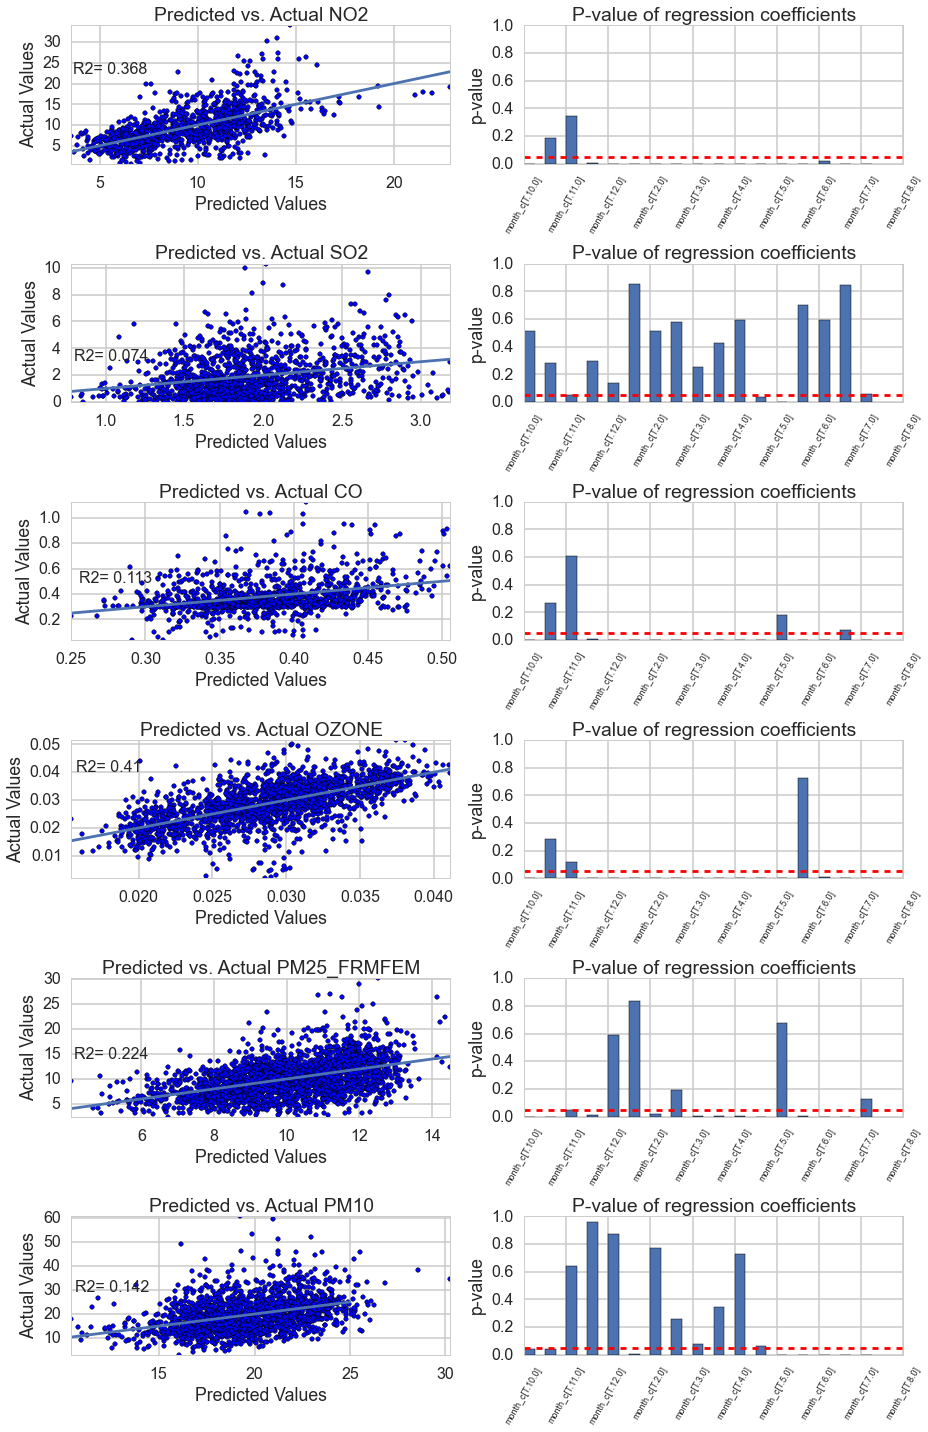

In [19]:
#Same visualization code
models_to_loop=[('NO2',no2_model_m,no2US_m),('NO2',no2_model_m,no2US_m),('SO2',so2_model_m,so2US_m),('SO2',so2_model_m,so2US_m),
                ('CO',co_model_m,coUS_m),('CO',co_model_m,coUS_m),('OZONE',ozone_model_m,ozoneUS_m),('OZONE',ozone_model_m,ozoneUS_m),
                ('PM25_FRMFEM',pm25_model_m,pm25US_m),('PM25_FRMFEM',pm25_model_m,pm25US_m),('PM10',pm10_model_m,pm10US_m),('PM10',pm10_model_m,pm10US_m)]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 20))
fig.set_tight_layout(True)

count = 0
for ax,j in zip(axes.ravel(),models_to_loop):
    count += 1
    if count % 2 != 0:
        ax.scatter(j[1].predict(),j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]])
        ax.plot([0,25], [0,25])
        ax.set_ylim((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).min(),(j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).max())
        ax.set_xlim(j[1].predict().min(),j[1].predict().max())
        ax.set_ylabel('Actual Values')
        ax.set_xlabel('Predicted Values')
        ax.annotate('R2= '+str(round(j[1].rsquared,3)),xy=(j[1].predict().min()*1.02,j[1].predict().max()*.98),xytext=(j[1].predict().min()*1.02,j[1].predict().max()*.98),fontsize=16)
        ax.set_title('Predicted vs. Actual '+j[0])
    else:
        ax.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],(sp.stats.t.sf(np.abs(j[1].tvalues), j[1].nobs-1)*2)[1:],.5)
        ax.set_ylim(0,1)
        ax.set_xticklabels(list(j[1].params.index)[1:],rotation=60,ha='center',fontsize=9)
        ax.set_ylabel('p-value')
        ax.set_title('P-value of regression coefficients')
        ax.axhline(0.05,color='red',ls='--')

We don't see much further improvement in the model fit (assessed by $R^2$) by adding in the monthly indicator. Perhaps most of the yearly variation in pollutants at a site can be explained by seasonality and the addition of monthly indicator variables will add little to our predictive model or statistical inference.

##Autocorrelation

As we mentioned, there may be autocorrelation in our analysis because of the repeated observations across time in the same stations. If this were the case, any inferences about relevant predictors would not be valid. One way to see if this is an issue is the Durbin-Watson statistic. We can calculate the value and compare it to the upper and lower bounds provided in the following table: https://www3.nd.edu/~wevans1/econ30331/Durbin_Watson_tables.pdf. If our statistic is lower than dL, then that's indicative of positive first-order autocorrelation. If it's larger than dU, then we wouldn't reject the null and conclude that there is not autocorrelation. If it's in between the two, it's uncertain but we would probably assume no autocorrelation to be conservative. 

*Yearly:* we have 6 predictors and roughly 100 observations in each regression (depending on missing values). Therefore dL~1.421 and dU~1.670.<br>

*Seasonally:* we have 9 predictors and over 200 observations in each regression. Therefore our dL=1.582 and dU=1.768.<br>

*Monthly:* we have 17 predictors and well over 200 observations. Therefore dL=1.495 and dU=1.860.

The calculations for each regression are as follows:

**Yearly:**

In [20]:
models_to_loop2=[('NO2',no2_model_y),('SO2',so2_model_y),('CO',co_model_y),('OZONE',ozone_model_y),
                ('PM25_FRMFEM',pm25_model_y),('PM10',pm10_model_y)]
for j in models_to_loop2:
    #Help with calculation from
    #http://connor-johnson.com/2014/02/18/linear-regression-with-python/
    print j[0] + ' Durbin-Watson: ' + str(np.sum( np.diff( j[1].resid.values )**2.0 ) / j[1].ssr)

NO2 Durbin-Watson: 1.79432203887
SO2 Durbin-Watson: 2.15012988749
CO Durbin-Watson: 2.10618905911
OZONE Durbin-Watson: 1.9170246049
PM25_FRMFEM Durbin-Watson: 1.8328092938
PM10 Durbin-Watson: 1.86624025658


These seem to have no autocorrelation as the statistics exceed the upper value. This is what we'd expect given that each site only has one observation as we've averaged across the year.

**Seasonally:**

In [21]:
models_to_loop2=[('NO2',no2_model_s),('SO2',so2_model_s),('CO',co_model_s),('OZONE',ozone_model_s),
                ('PM25_FRMFEM',pm25_model_s),('PM10',pm10_model_s)]
for j in models_to_loop2:
    #Help with calculation from
    #http://connor-johnson.com/2014/02/18/linear-regression-with-python/
    print j[0] + ' Durbin-Watson: ' + str(np.sum( np.diff( j[1].resid.values )**2.0 ) / j[1].ssr)

NO2 Durbin-Watson: 1.06555155718
SO2 Durbin-Watson: 0.948879744632
CO Durbin-Watson: 1.08280570172
OZONE Durbin-Watson: 1.43205910107
PM25_FRMFEM Durbin-Watson: 1.24797585862
PM10 Durbin-Watson: 1.10057620639


With the seasonal data, we're encountering a bit of significant positive first-order autocorrelation in our analysis as we've included multiple observations across time for each site. This might suggest that even though we had a better fit for a few of the pollutants using the seasonal data, we may need to use a time series model, or specified correlation structure of the outcome variables, to model these data appropriately.

**Monthly:**

In [22]:
models_to_loop2=[('NO2',no2_model_m),('SO2',so2_model_m),('CO',co_model_m),('OZONE',ozone_model_m),
                ('PM25_FRMFEM',pm25_model_m),('PM10',pm10_model_m)]
for j in models_to_loop2:
    #Help with calculation from
    #http://connor-johnson.com/2014/02/18/linear-regression-with-python/
    print j[0] + ' Durbin-Watson: ' + str(np.sum( np.diff( j[1].resid.values )**2.0 ) / j[1].ssr)

NO2 Durbin-Watson: 0.578506899476
SO2 Durbin-Watson: 0.450118623501
CO Durbin-Watson: 0.60051280395
OZONE Durbin-Watson: 1.01105263122
PM25_FRMFEM Durbin-Watson: 0.85913556615
PM10 Durbin-Watson: 0.855268572346


The autocorrelation using the monthly data is not suprisingly substantially worse as we now have 12 observations for site. If we were to use the monthly data, we'd certainly need to account for the correlation in Y's.

##Selecting Independent Variables

Given that the seasonal model seems to work the best of the previous (barring the autocorrelation issue that we still need to deal with) we're going to just focus on that model. In the previous models, we just added all predictors in. Perhaps we can use feature selection based on the correlations in the exploratory data analysis. For each regression, we can include predictors that have a correlation coefficient greater than 0.20 (a very liberal cutoff) in the absolute value during at least one season. This may not be the best feature selection process, but it may get rid of features that aren't really adding much information. Furthermore, we will ignore multicollinearity issues for this section as we are using feature selection to try to improve prediction, not draw statistical inference.

In [23]:
#Create dictionary which we will populate with the predictors for each model
predictors = {}
pollutants = ['CO','NO2','OZONE','PM25_FRMFEM','PM10','SO2']
#Loop through pollutants
for p in pollutants:
    #initiate and empty list
    predictors[p]=[]
    #Pick out the possible predictors
    choices = ['Pressure','Temp','Wind','Precip','popdense2010','pt_frac','car_frac','other_frac']
    #Add season and the particular polllutant to the list
    choices = [p,'season'] + choices
    #For each season do the correlation assessment
    for seasonI in ['Winter','Spring','Summer','Fall']:
        #makde a df of the predictors for the particular season only
        sel_df=SeasonDat[SeasonDat['season']==seasonI][choices]
        #Get correaltions
        corrmat = sel_df.corr()
        #For each variable, check if correlation is greater than .2
        #and append to list
        for var,val in zip(list(corrmat.iloc[:1].columns),corrmat.iloc[:1].values.tolist()[0]):
            if (abs(val) > 0.2) and (var != p):
                predictors[p].append(var)

In [25]:
#create a dictionary of models and print out the formula for each model
model_dict = {}
pollutants = ['CO','NO2','OZONE','PM25_FRMFEM','PM10','SO2']
dfs = [coUS_s,no2US_s,ozoneUS_s,pm25US_s,pm10US_s,so2US_s] 
trimmed_dfs = {}
print 'Formulas for each pollutant model'
for p, df in zip(pollutants,dfs):
    cleandf=df[[p,'season']+list(set(predictors[p]))].dropna()
    trimmed_dfs[p] = cleandf
    base = p+' ~ season + '
    for i in set(predictors[p]):
        base = base + i + ' + '
    model = base[:-3]
    print model
    model_dict[p] =  ols(model,cleandf).fit()

Formulas for each pollutant model
CO ~ season + Precip + Wind
NO2 ~ season + pt_frac + Pressure + popdense2010 + car_frac
OZONE ~ season + pt_frac + popdense2010 + Temp + car_frac + Pressure + Precip + Wind
PM25_FRMFEM ~ season + Temp + car_frac + other_frac + Pressure + Precip + Wind
PM10 ~ season + Pressure + Precip + Temp + other_frac
SO2 ~ season + Pressure + other_frac


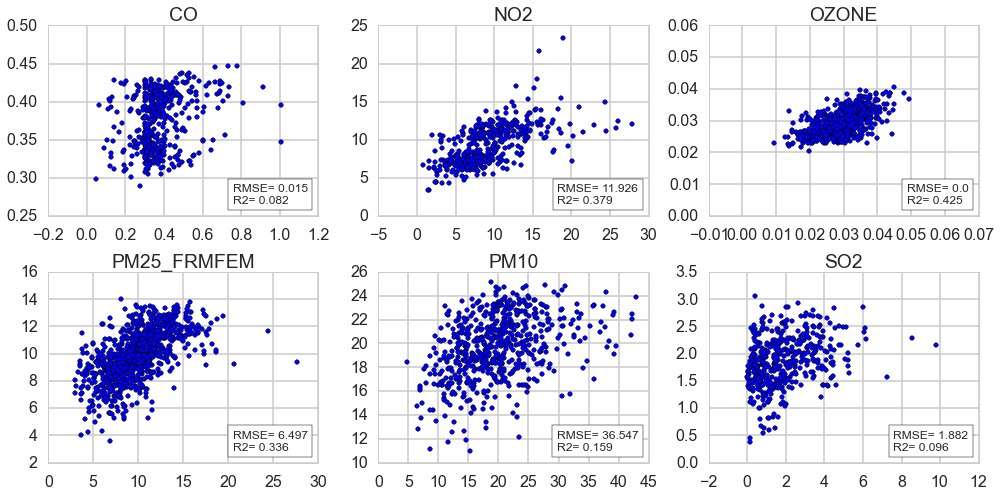

In [25]:
#Use this package to help make cleaner graphs
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
fig.set_tight_layout(True)
#Plot the predicted versus fitted for each of these feature selected
#regressions. recored RMSE and R2
for ax,p in zip(axes.ravel(),pollutants):
    ax.scatter(trimmed_dfs[p][p],model_dict[p].predict())
    ax.set_title(p)
    at = AnchoredText('RMSE= '+str(round(np.mean((trimmed_dfs[p][p] - model_dict[p].predict()) ** 2),3))+'\nR2= '+str(round(model_dict[p].rsquared,3)),
                  prop=dict(size=12), frameon=True,
                  loc=4,
                  )
    ax.add_artist(at)
  

Feature selection hasn't made drastic improvements in any of the evaulation metrics, but we did see improvements for the $R^2$ of $NO_2$ (.37 to .38), $PM2.5$ (.25 to .34), $PM10$ (.15 to .16), and $SO_2$ (.09 to .10) with very little change in $CO$ and $Ozone$ $R^2$. Given that these models are more simplistic and improve the fit generally, the feature selection appears somewhat successful and we will go forward with these.

#Validation of Basic Regression in France Cities


At this point, we've avoided drawing any statistical inference, but have generated a predictive model for each pollutant. Given that we are only doing prediction at this point, we don't have to be concerned about the violation in assumptions that we've clearly showed above (autocorrelated Y's). 

To assess the generalizability of these models, we may be interested in seeing how the seasonal model with feature selection for each pollutant generalizes to cities outside the US. To do this, we will look at the French city data.

In [26]:
#Load French City Data
FranceYearDat = pd.read_csv('FranceYearDat.csv')
FranceSeasonDat = pd.read_csv('FranceSeasonDat.csv')

In [27]:
#Rename columns so they match the columns precisely in the other data
FranceSeasonDat.columns = ['season','SO2','NO2','CO','OZONE','PM10','PM25','id','city','population','popdense2010','area','other_frac','car_frac',
                        'pt_frac','Car','PT','Other','Temp','RH','Pressure','Wind','Precip']
FranceYearDat.columns = ['CO','NO2','OZONE','PM10','PM25','SO2','city','id','population','popdense2010','area','other_frac','car_frac',
                        'pt_frac','Car','PT','Other','latitude','longitude','Precip','Pressure','RH','site','Temp','Wind']


In [28]:
from sklearn.linear_model import LinearRegression
X_usdict={}
y_usdict={}
rmse_lm={}
#For each pollutant, run the create a dictionary of
#a cleaned dataframe with no NaNs
#Also recode season to dummy variables
for p in pollutants:
    lm=LinearRegression()
    X_usdict[p] = trimmed_dfs[p].drop(p,axis=1)
    X_usdict[p]['winter'] = [1 if x=='Winter' else 0 for x in X_usdict[p]['season']]
    X_usdict[p]['spring'] = [1 if x=='Spring' else 0 for x in X_usdict[p]['season']]
    X_usdict[p]['summer'] = [1 if x=='Summer' else 0 for x in X_usdict[p]['season']]
    X_usdict[p] = X_usdict[p].drop('season',axis=1)
    y_usdict[p] = trimmed_dfs[p][p]

#Go through each pollutant again
for p in pollutants:
    #Fit the model using US data and the predictors we selected
    lm.fit(X_usdict[p],y_usdict[p])
    #Get the respective France dataset for each pollutant
    #In the PM25 case, we need to make sure that we acknowledge
    #a slight difference in variable names
    if p == 'PM25_FRMFEM':
        france_trim = FranceSeasonDat[['PM25','season']+list(set(predictors[p]))].dropna()
    else:
        france_trim = FranceSeasonDat[[p,'season']+list(set(predictors[p]))].dropna()
    france_trim['winter'] = [1 if x=='Winter' else 0 for x in france_trim['season']]
    france_trim['spring'] = [1 if x=='Spring' else 0 for x in france_trim['season']]
    france_trim['summer'] = [1 if x=='Summer' else 0 for x in france_trim['season']]
    france_trim = france_trim.drop('season',axis=1)

    #Create the X matrix and y vector for France
    if p == 'PM25_FRMFEM':
        france_X = france_trim.drop('PM25',axis=1)
        france_y = france_trim['PM25']
    else:
        france_X = france_trim.drop(p,axis=1)
        france_y = france_trim[p]

    #Create a dictionary of RMSE for US that we can use later
    rmse_lm[p] = np.mean((y_usdict[p] - lm.predict(X_usdict[p])) ** 2)
    #For OZONE, we want to round this to more decimals because the number is so small
    if p == 'OZONE':
        print p
        print 'RMSE US Data: ' + str(round(np.mean((y_usdict[p] - lm.predict(X_usdict[p])) ** 2),5))
        print 'RMSE France Data: ' + str(round(np.mean((france_y - lm.predict(france_X)) ** 2),5))  
    #For the rest, we print the RMSE to 3 decimals
    else:
        print p
        print 'RMSE US Data: ' + str(round(np.mean((y_usdict[p] - lm.predict(X_usdict[p])) ** 2),3))
        print 'RMSE France Data: ' + str(round(np.mean((france_y - lm.predict(france_X)) ** 2),3))

CO
RMSE US Data: 0.015
RMSE France Data: 0.021
NO2
RMSE US Data: 11.926
RMSE France Data: 187.624
OZONE
RMSE US Data: 2e-05
RMSE France Data: 4e-05
PM25_FRMFEM
RMSE US Data: 6.497
RMSE France Data: 295.941
PM10
RMSE US Data: 36.547
RMSE France Data: 365.678
SO2
RMSE US Data: 1.882
RMSE France Data: 12.451


This doesn't look like it generalizes very well at all given the large difference in RMSE (enormous in some cases). It could be differences in the data collection method, or it could simply be that emissions are different in France than the US. Regardless, as a predictive model, we would not feel that we would have very much ability to predict pollutants externally of the US with this model we've developed. 

One way to investigate the lack of generalizability of our predictive models is to fit the same regression models but with the France data. Then we can compare the France and US models and see what coefficients are most different between the 2. It's not the most principled approach (as we'll be looking at the testing data), but given that our current models aren't generalizable, it's at least worth looking into. It could be a data error in which case our evaluation isn't fair to begin with.

In [29]:
from sklearn.linear_model import LinearRegression
X_usdict={}
y_usdict={}
#Make all the US data into a y_dict and an X_dict
#With entries for each pollutant
for p in pollutants:
    X_usdict[p] = trimmed_dfs[p].drop(p,axis=1)
    X_usdict[p]['winter'] = [1 if x=='Winter' else 0 for x in X_usdict[p]['season']]
    X_usdict[p]['spring'] = [1 if x=='Spring' else 0 for x in X_usdict[p]['season']]
    X_usdict[p]['summer'] = [1 if x=='Summer' else 0 for x in X_usdict[p]['season']]
    X_usdict[p] = X_usdict[p].drop('season',axis=1)
    y_usdict[p] = trimmed_dfs[p][p]
    lm=LinearRegression()

for p in pollutants:
    #Fit the US model
    lm.fit(X_usdict[p],y_usdict[p])
    #Pring out the coefficients
    print 'US parameter estimates '+p
    print list(X_usdict[p].columns)
    print lm.coef_
    #Get the respective French data for the pollutant
    #simply dropping missing values (again, things
    #seem to be mostly missing at random)
    if p == 'PM25_FRMFEM':
        france_trim = FranceSeasonDat[['PM25','season']+list(set(predictors[p]))].dropna()
    else:
        france_trim = FranceSeasonDat[[p,'season']+list(set(predictors[p]))].dropna()
    france_trim['winter'] = [1 if x=='Winter' else 0 for x in france_trim['season']]
    france_trim['spring'] = [1 if x=='Spring' else 0 for x in france_trim['season']]
    france_trim['summer'] = [1 if x=='Summer' else 0 for x in france_trim['season']]
    france_trim = france_trim.drop('season',axis=1)

    if p == 'PM25_FRMFEM':
        france_X = france_trim.drop('PM25',axis=1)
        france_y = france_trim['PM25']
    else:
        france_X = france_trim.drop(p,axis=1)
        france_y = france_trim[p]
    #Fit the France models and print the coefficients
    lm.fit(france_X,france_y)
    print 'France parameter estimates '+ p
    print list(france_X.columns)
    print lm.coef_

US parameter estimates CO
['Precip', 'Wind', 'winter', 'spring', 'summer']
[ -6.38353460e-05  -5.93516341e-03   1.29465210e-02  -4.44668583e-02
  -6.38463802e-02]
France parameter estimates CO
['Precip', 'Wind', 'winter', 'spring', 'summer']
[  3.13377048e-05  -1.71324756e-02   9.43941320e-02  -8.16908494e-02
  -1.30339721e-01]
US parameter estimates NO2
['pt_frac', 'Pressure', 'popdense2010', 'car_frac', 'winter', 'spring', 'summer']
[  7.84873562e+01  -2.43775608e-01   1.22594647e-04   3.80212092e+01
   1.02415701e+00  -3.89840171e+00  -4.65732016e+00]
France parameter estimates NO2
['pt_frac', 'Pressure', 'popdense2010', 'car_frac', 'winter', 'spring', 'summer']
[ -1.90920922e+01  -1.41093102e-01   3.09961039e-03  -4.09163605e+01
   2.27390297e+00  -2.64951036e+00  -4.74006989e+00]
US parameter estimates OZONE
['pt_frac', 'popdense2010', 'Temp', 'car_frac', 'Pressure', 'Precip', 'Wind', 'winter', 'spring', 'summer']
[ -4.10110304e-04  -1.47416462e-06   5.97525575e-05   5.92048345e-0

It seems that their is a large discrepancy with the transit variables -- they often switch signs between the France data and the US data. We know that we took those from fairly different sources, so maybe it's not comparable. Looking at correlations of the variables in a heatmap, we see quite differnt patterns with the transit and pollutants in the French data than the US data.

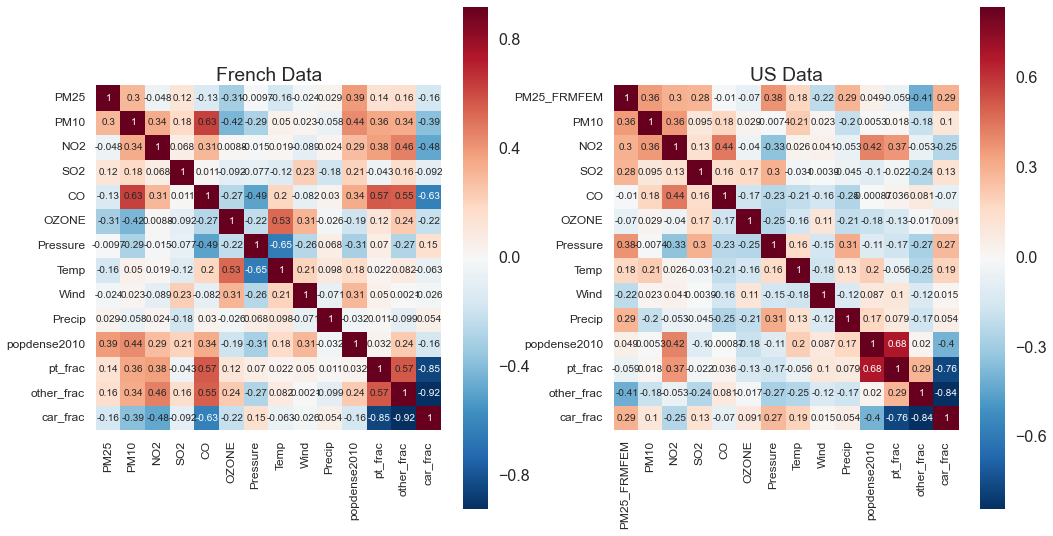

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 9))
#MAke france dataframe
df = FranceYearDat[['PM25','PM10','NO2','SO2','CO','OZONE','Pressure','Temp','Wind','Precip','popdense2010','pt_frac','other_frac','car_frac']]
#calculate correlations
corrmat = df.corr()
#Make heatmap
sns.heatmap(corrmat, vmax=.8, square=True,annot=True,ax=axes[0])
#Same with US
df = YearDat[['PM25_FRMFEM','PM10','NO2','SO2','CO','OZONE','Pressure','Temp','Wind','Precip','popdense2010','pt_frac','other_frac','car_frac']]
corrmat = df.corr()
sns.heatmap(corrmat, vmax=.8, square=True,annot=True,ax=axes[1])
axes[0].set_title('French Data')
axes[0].tick_params(labelsize=12)
axes[1].set_title('US Data')
axes[1].tick_params(labelsize=12)

This could mean one or more of three things:
1. The relationship between transportation style and pollutants is different in both countries. This could be possible, but seems unlikely given that a pollutant in the US is the same as a pollutant in France -- the chemistry should be the same.
2. More likely, the public transit data isn't really comparable between the two countries. The source of European transit data may not be the most robust -- some of it was relevant to the entire urban area and some seemed more city specific. This could have skewed the variable a bit as was discussed in the data collection stage.
3. The fraction of transportation may be completely different between countries so our model doesn't generalize well. The difference in relationship could be largely attributable to the very different modes of transportation in France vs. the US.

Just as a curiosity, what if we fit models only using the weather and population density? These are the more reliable data points as they were collected from analagous data soruces. The weather will all come from NOAA, the pollutants are all recorded with what I'd imagine are comparable devices, and the demographic data should be fairly similar. It's really only the transit data that was questionably comparable from the beginning.

In [31]:
#Do new feature selection based on the non-transity predictors
#Same structure as code before
predictors2 = {}
pollutants = ['CO','NO2','OZONE','PM25_FRMFEM','PM10','SO2']
for p in pollutants:
    predictors2[p]=[]
    choices_nontrans2 = ['Pressure','Temp','Wind','Precip','popdense2010']
    choices_nontrans2 = [p,'season'] + choices_nontrans2
    for seasonI in ['Winter','Spring','Summer','Fall']:
        sel_df_nontrans2=SeasonDat[SeasonDat['season']==seasonI][choices_nontrans2]
        corrmat_nontrans2 = sel_df_nontrans2.corr()
        for var,val in zip(list(corrmat_nontrans2.iloc[:1].columns),corrmat_nontrans2.iloc[:1].values.tolist()[0]):
            if (abs(val) > 0.2) and (var != p):
                predictors2[p].append(var)

In [32]:
#Create dictionary that has the model for each pollutant
#Print out the formulas for the models
model_dict2 = {}
pollutants = ['CO','NO2','OZONE','PM25_FRMFEM','PM10','SO2']
dfs = [coUS_s,no2US_s,ozoneUS_s,pm25US_s,pm10US_s,so2US_s] 
trimmed_dfs2 = {}
for p, df in zip(pollutants,dfs):
    cleandf=df[[p,'season']+list(set(predictors2[p]))].dropna()
    trimmed_dfs2[p] = cleandf
    base = p+' ~ season + '
    for i in set(predictors2[p]):
        base = base + i + ' + '
    model = base[:-3]
    print model
    model_dict2[p] =  ols(model,cleandf).fit()

CO ~ season + Precip + Wind
NO2 ~ season + Pressure + popdense2010
OZONE ~ season + Pressure + Precip + popdense2010 + Temp + Wind
PM25_FRMFEM ~ season + Pressure + Precip + Wind + Temp
PM10 ~ season + Pressure + Precip + Temp
SO2 ~ season + Pressure


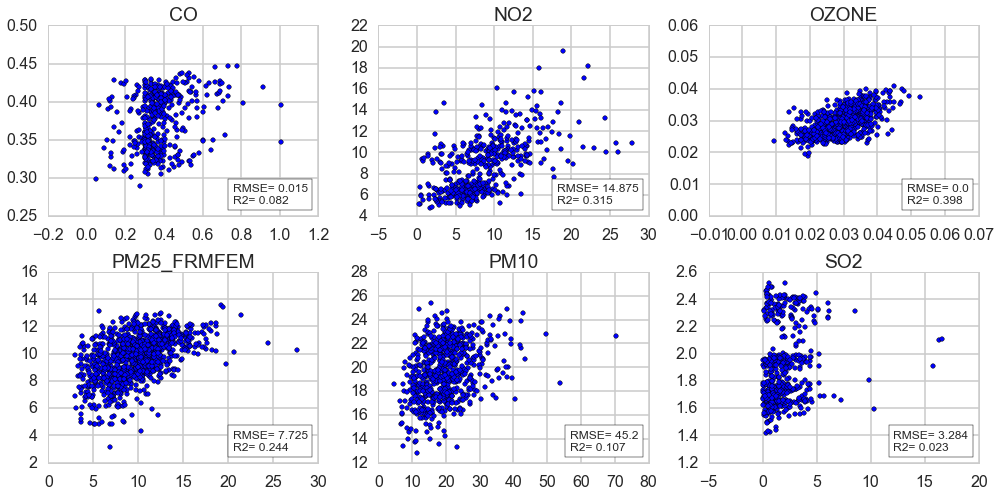

In [33]:
#Make graphs of the fitted vs. predicted
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
fig.set_tight_layout(True)
for ax,p in zip(axes.ravel(),pollutants):
    ax.scatter(trimmed_dfs2[p][p],model_dict2[p].predict())
    ax.set_title(p)
    at = AnchoredText('RMSE= '+str(round(np.mean((trimmed_dfs2[p][p] - model_dict2[p].predict()) ** 2),3))+'\nR2= '+str(round(model_dict2[p].rsquared,3)),
                  prop=dict(size=12), frameon=True,
                  loc=4,
                  )
    ax.add_artist(at)

We lose some of our fit by dropping the transit variables, but not actually that much overall as the $R^2$ doesn't change drastically, especially for the best models. Let's recompare the RMSE using the French City data as if this was the model generated from the beginning.

In [34]:
#Create the X_usdict2 for the X matrix for US for each pollutant
#Creat the y_usdict2 for the y vector for US for each pollutant
from sklearn.linear_model import LinearRegression
X_usdict2={}
y_usdict2={}
for p in pollutants:
    lm=LinearRegression()
    X_usdict2[p] = trimmed_dfs2[p].drop(p,axis=1)
    X_usdict2[p]['winter'] = [1 if x=='Winter' else 0 for x in X_usdict2[p]['season']]
    X_usdict2[p]['spring'] = [1 if x=='Spring' else 0 for x in X_usdict2[p]['season']]
    X_usdict2[p]['summer'] = [1 if x=='Summer' else 0 for x in X_usdict2[p]['season']]
    X_usdict2[p] = X_usdict2[p].drop('season',axis=1)
    y_usdict2[p] = trimmed_dfs2[p][p]

In [35]:
#This is analagous to previous code that prints out the
#RMSE for each model both on the data it's fit to (US) and 
#the French data to see how it generalizes
rmse_lm2 = {}
for p in pollutants:
    lm.fit(X_usdict2[p],y_usdict2[p])
    if p == 'PM25_FRMFEM':
        france_trim = FranceSeasonDat[['PM25','season']+list(set(predictors2[p]))].dropna()
    else:
        france_trim = FranceSeasonDat[[p,'season']+list(set(predictors2[p]))].dropna()
    france_trim['winter'] = [1 if x=='Winter' else 0 for x in france_trim['season']]
    france_trim['spring'] = [1 if x=='Spring' else 0 for x in france_trim['season']]
    france_trim['summer'] = [1 if x=='Summer' else 0 for x in france_trim['season']]
    france_trim = france_trim.drop('season',axis=1)

    if p == 'PM25_FRMFEM':
        france_X = france_trim.drop('PM25',axis=1)
        france_y = france_trim['PM25']
    else:
        france_X = france_trim.drop(p,axis=1)
        france_y = france_trim[p]
    
    rmse_lm2[p] = np.mean((y_usdict2[p] - lm.predict(X_usdict2[p])) ** 2)
    if p == 'OZONE':
        print p
        print 'RMSE US Data: ' + str(round(np.mean((y_usdict2[p] - lm.predict(X_usdict2[p])) ** 2),5))
        print 'RMSE France Data: ' + str(round(np.mean((france_y - lm.predict(france_X)) ** 2),5))    
    else:
        print p
        print 'RMSE US Data: ' + str(round(np.mean((y_usdict2[p] - lm.predict(X_usdict2[p])) ** 2),3))
        print 'RMSE France Data: ' + str(round(np.mean((france_y - lm.predict(france_X)) ** 2),3))

CO
RMSE US Data: 0.015
RMSE France Data: 0.021
NO2
RMSE US Data: 14.875
RMSE France Data: 35.514
OZONE
RMSE US Data: 3e-05
RMSE France Data: 5e-05
PM25_FRMFEM
RMSE US Data: 7.725
RMSE France Data: 97.985
PM10
RMSE US Data: 45.2
RMSE France Data: 73.002
SO2
RMSE US Data: 3.284
RMSE France Data: 1.908


The results are somewhat better now. We don't have great testing performance for NO2, ozone, PM2.5 or PM10, but it's okay for CO and SO2. And in general, it's definitely improved for all pollutants. I don't think we are able to generalize our models outside the US and would need to collect more data (both in terms of completing missing data we have here and gathering additional potential features that predict pollutant levels) to try to resolve this.

But moving forward, it could be interesting to look at residual plots for each of these regressions to see if there are particular observations contributing to the higher RMSE.

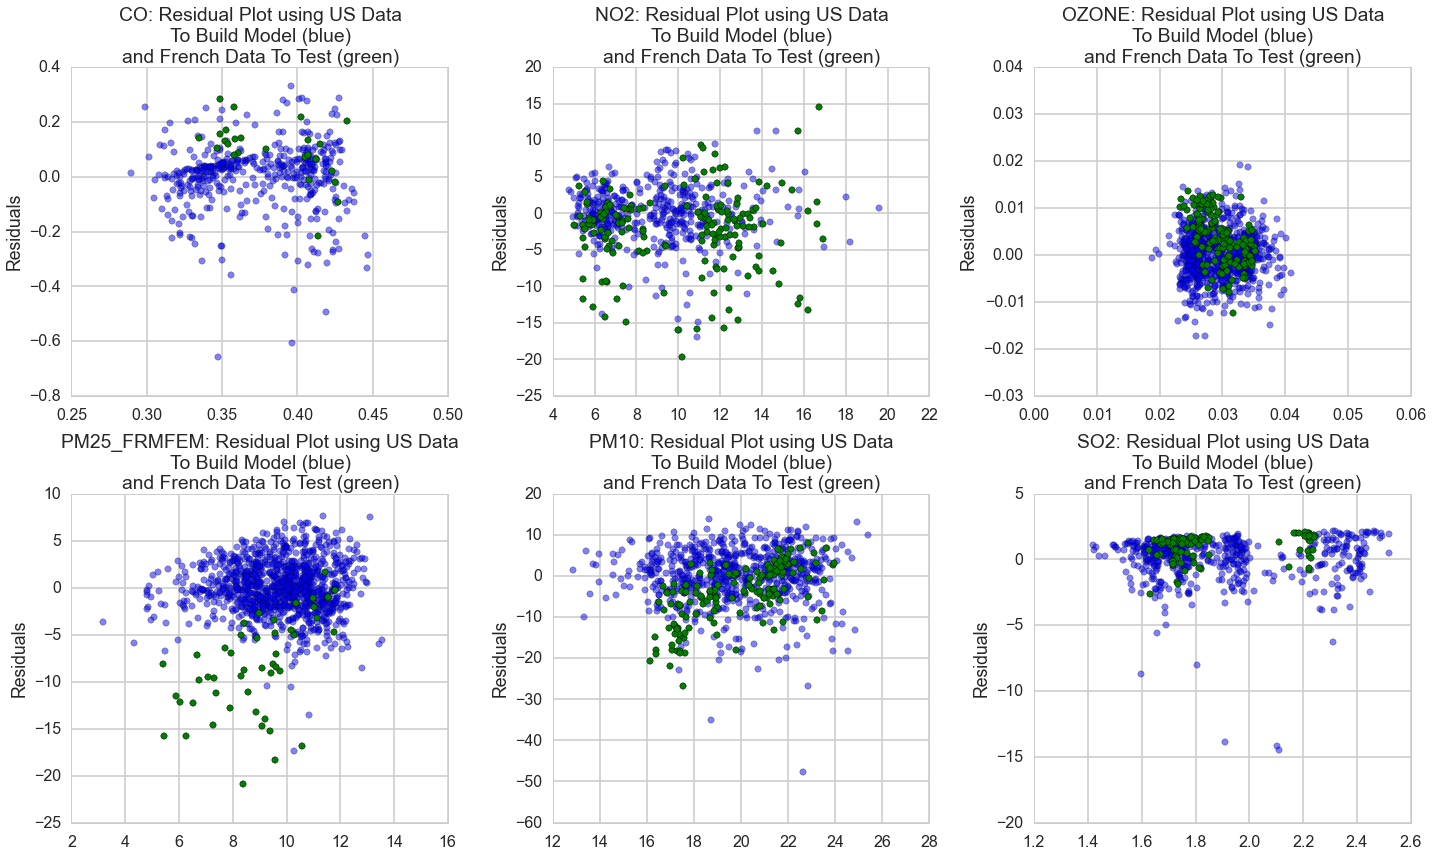

In [36]:
#Using some of the previous lab code
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
fig.set_tight_layout(True)
for ax,p in zip(axes.ravel(),pollutants):
    lm.fit(X_usdict2[p],y_usdict2[p])
    if p == 'PM25_FRMFEM':
        france_trim = FranceSeasonDat[['PM25','season']+list(set(predictors2[p]))].dropna()
    else:
        france_trim = FranceSeasonDat[[p,'season']+list(set(predictors2[p]))].dropna()
        
    france_trim['winter'] = [1 if x=='Winter' else 0 for x in france_trim['season']]
    france_trim['spring'] = [1 if x=='Spring' else 0 for x in france_trim['season']]
    france_trim['summer'] = [1 if x=='Summer' else 0 for x in france_trim['season']]
    france_trim = france_trim.drop('season',axis=1)

    if p == 'PM25_FRMFEM':
        france_X = france_trim.drop('PM25',axis=1)
        france_y = france_trim['PM25']
    else:
        france_X = france_trim.drop(p,axis=1)
        france_y = france_trim[p]
    
    ax.scatter(lm.predict(X_usdict2[p]), lm.predict(X_usdict2[p]) - y_usdict2[p], c='b', s=40, alpha=0.5)
    ax.scatter(lm.predict(france_X), lm.predict(france_X) - france_y, c='g', s=40)
    ax.set_title(p+': Residual Plot using US Data \nTo Build Model (blue) \nand French Data To Test (green)')
    ax.set_ylabel('Residuals')

Generally, it looks as if the France data falls within the US data in terms of residuals pretty decently. Because of missing data, we see very few France data points of CO and not a ton of PM25 either. In the case of the PM25, the French city residuals are quite far from 0 which is why there is such a high RMSE for the French data there. The other 4 plots look decent. It's interesting to see the two groups of $SO_2$ that are well divided. The residuals for NO2, OZONE, and PM10 look pretty much like we'd like to see.

We would like to note that we realize that we sort of cheated a little by looking at the testing dataset and doing the analysis twice. However, we find ourselves in a tough position in that we think the transit data from France cities wasn't really captured in the same way as the US cities. If the two variables weren't comparable, then of course our model would not generalize. Given these circumstances, I don't think we've cheated too much and can say that these are our best predictive models for the time being.

##Honing in on the $NO_2$ and $OZONE$ Models for Statistical Inference

Of all the models, the $NO_2$  and $ozone$ models look most promising based on the $R^2$. Given suck low $R^2$ for the other models, we will stick just to these two pollutants in trying to draw statistical inference. To draw any statistical inference, we need to address the fact that our outcome appears to have significant autocorrelation. Additionally, we should check other assumptions of the linear regression to see that they hold.

###Generalized Estimating Equations

One way we may want to draw some inference about our predictive models is to use a Generalized Estimating Equations (GEE) approach. These models help when we have correlated observations: "Generalized Estimating Equations estimate generalized linear models for panel, cluster or repeated measures data when the observations are possibly correlated withing a cluster but uncorrelated across cluster." (http://statsmodels.sourceforge.net/devel/gee.html). This pretty well describes our situation as we have multiple observations across season that will likely be correlated with one another. Because we know there is a strong seasonal effect this we would like to include it in the model, and a GEE model will help us to draw valid statistical inferences by using a more robust estimation procedure.

In running a GEE model, there are 2 main choices to make: 1. determining the family and 2. determining the correlation structure. 

When it comes to the correlation structure, we can probably use the Exchangeable structure or Autoregressive sturture. Given that our clusters are small and evenly spaced out in time temporally, but relatively the same in size (generally 3 - 4) an Exchangeable correlation structure may work okay here. It is also the "go-to" approach and given that the whole goal of GEE is to provide robust estimates will likely work decently.

For the family structure a Gaussian family probably makes decent sense given that both ozone and $NO_2$ are fairly normally distributed.

Help from:
http://stats.stackexchange.com/questions/83577/gee-choosing-proper-working-correlation-structure
http://nbviewer.ipython.org/urls/umich.box.com/shared/static/zyl08wsmxwoh6ts70v4o.ipynb

**$NO_2$**<br>
The strategy here was to simply add all variables into the model to see the relative contribution of the variables when the others are present. Only population density was included as a demographic variable.

In [37]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [39]:
#make the dataframe for the model (remove missings)
no2_gee_dat = SeasonDat[['NO2','Pressure','Wind','Precip','Temp','popdense2010','season','CBSA Name']].dropna()
#Center the variables to improve interpretation of intercept
for pred in ['Pressure','Wind','Precip','Temp','popdense2010']:
    no2_gee_dat[pred] = no2_gee_dat[pred] - no2_gee_dat[pred].mean()

In [40]:
#Fit the model and print a summary
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()
mod = smf.gee("NO2 ~  Precip + Temp + Pressure + Wind + popdense2010 + season", "CBSA Name", no2_gee_dat,
              cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())

                               GEE Regression Results                              
Dep. Variable:                         NO2   No. Observations:                  425
Model:                                 GEE   No. clusters:                      112
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 3.8
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Wed, 09 Dec 2015   Scale:                          15.836
Covariance type:                    robust   Time:                         09:38:04
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           10.2209      0.428     23.858      0.000         9.381

Beyond the basic summary output, we can also check the correlation between out clusters (in this case a cluster is a site with 4 observations - 1 for each season).

In [41]:
ind.summary()

'The correlation between two observations in the same cluster is 0.820'

Within a site, the $NO_2$ measures are highly correlated which is what we'd expect.

Let's check the RMSE of this model compared to the linear model.

In [42]:
no2_rmse = np.mean((no2_gee_dat['NO2'] - res.predict(no2_gee_dat[['NO2','Pressure','Wind','Precip','Temp','popdense2010','season','CBSA Name']])) ** 2)
print "GEE Model RMSE NO2: " + str(no2_rmse)
mod = smf.GEE.from_formula("NO2 ~  Precip + Temp + Pressure + Wind + popdense2010 + season", "CBSA Name", no2_gee_dat)
res_lm = mod.fit(cov_type='naive')
no2_lm_rmse = np.mean((no2_gee_dat['NO2'] - res_lm.predict(no2_gee_dat[['NO2','Pressure','Wind','Precip','Temp','popdense2010','season','CBSA Name']])) ** 2)
print "Linear Model RMSE NO2: " + str(no2_lm_rmse)

GEE Model RMSE NO2: 15.5009291065
Linear Model RMSE NO2: 14.7004784357


There was only a small increase in the RMSE, but now we can say a bit more about inference. We expected the RMSE to get worse with the GEE given we made it a more robust model (probably less powerful). It looks like there is a significant effect of season and population density on $NO_2$. There is significantly lower levels of $NO_2$ in the summer and spring compared to the sall and similar levels of $NO_2$ in the winter compared to the fall. In the average size city with average weather in the fall, we'd expect a $NO_2$ concentrations of about 10.2 ppb. In the spring we'd expect average $NO_2$ of around 7.5 ppb, the summer 7ppb, and the winter around 10.8ppb. These all fall well within the Good AQI, so in general US cities look pretty good.

There is a significant positive relationship between $NO_2$ and population density. For every 100 people/sq mile increase there is a 0.3 ppb increase in $NO_2$. There is a negative relationship with Wind, for every 1 knot increase in average wind speed, there is a .45 ppb decrease in $NO_2$.

*check model assumptions*<br>
We know from the EDA that relationships between the individual predictors and the pollutant appear reasonably linear. They don't seem to indicate strong curvature at the very least. In terms of multicollinearity, from EDA we know that none of our predictors are strongly correlated so we are probably fine here. We can look at residuals below to check homoscedasticity.

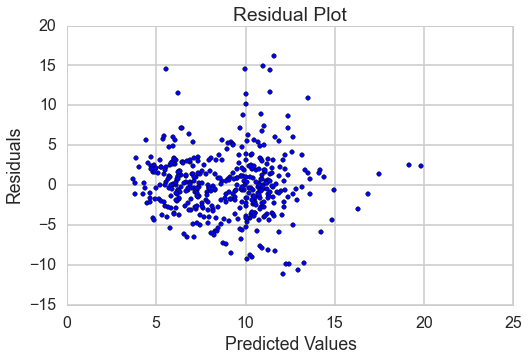

In [43]:
#Residual Plot
fig = plt.subplots(figsize=(8,5))
plt.scatter(res.predict(no2_gee_dat[['NO2','Pressure','Wind','Precip','Temp','popdense2010','season','CBSA Name']]),
         no2_gee_dat['NO2'] - res.predict(no2_gee_dat[['NO2','Pressure','Wind','Precip','Temp','popdense2010','season','CBSA Name']]))
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Residuals from this plot look good in general as they don't seem to have any distinct patterns.

**OZONE**

We can fit the same kind of model for ozone as well.

In [44]:
#ozone gee dataset
ozone_gee_dat = SeasonDat[['OZONE','Wind','popdense2010','pt_frac','Pressure','season','Precip','Temp','CBSA Name']].dropna()
#Center predictors to help with interpretation of intercept
for pred in ['Pressure','Wind','Precip','Temp','popdense2010']:
    ozone_gee_dat[pred] = ozone_gee_dat[pred] - ozone_gee_dat[pred].mean()

In [45]:
#Same model as described above using just the feature selected variables
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()
mod = smf.gee("OZONE ~ Wind + popdense2010 + Pressure + Precip + Temp + season", "CBSA Name", ozone_gee_dat,
              cov_struct=ind, family=fam)
res2 = mod.fit()
print(res2.summary())

                               GEE Regression Results                              
Dep. Variable:                       OZONE   No. Observations:                  727
Model:                                 GEE   No. clusters:                      203
Method:                        Generalized   Min. cluster size:                   2
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 3.6
Dependence structure:         Exchangeable   Num. iterations:                    12
Date:                     Wed, 09 Dec 2015   Scale:                           0.000
Covariance type:                    robust   Time:                         09:39:15
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            0.0262      0.000     64.503      0.000         0.025

In [46]:
#Compare the RMSE of GEE to LM
ozone_rmse = np.mean((ozone_gee_dat['OZONE'] - res2.predict(ozone_gee_dat[['Wind','popdense2010','Pressure','season','pt_frac','Precip','Temp','CBSA Name']])) ** 2)
print "GEE Model RMSE OZONE: " + str(ozone_rmse)
mod = smf.GEE.from_formula("OZONE ~  Precip + Temp + Pressure + Wind + popdense2010 + season", "CBSA Name", ozone_gee_dat)
res_lm = mod.fit(cov_type='naive')
ozone_lm_rmse = np.mean((ozone_gee_dat['OZONE'] - res_lm.predict(ozone_gee_dat[['OZONE','Pressure','Wind','Precip','Temp','popdense2010','season','CBSA Name']])) ** 2)
print "Linear Model RMSE OZONE: " + str(ozone_lm_rmse)

GEE Model RMSE OZONE: 2.33182187822e-05
Linear Model RMSE OZONE: 2.24360078391e-05


In [47]:
ind.summary()

'The correlation between two observations in the same cluster is 0.499'

Again, there was just a minor change in the RMSE and now we can make statistical inferences from the model given that we have a robust covariance structure. We see highly significant effects of many variables. Because of the small size of the units (ppm) it may be easier to intepret this in ppb (multiplying by 1000). The Air Quality Index (AQI) scores generally look at ppb when defining cutoffs.

There are significantly higher levels of ozone in all seasons over the fall. Concentrations are on average 4 ppb higher in the winter, 2 ppb higher in the summer, and 7 ppb higher in the spring -- holding other variables constant. In a city with average population density and average weather, the average concentration of ozone in the fall is 26.2 ppb. In spring it's 33.2 ppb, in summer 28.4 ppb, and winter 29.8 ppb.

For every 1 degree F increase in temperature, there is a 0.2 ppb increase in ozone. For every 1 inch of rainfall (~25 mm) there is a decrease of about 0.2 ppb in ozone. For every 100 people/square mile there is about a 0.2 ppb decrease in $O_3$.

It's useful to intepret all these variables together in one model. We can see the relative contributions on anthropogenic and natural sources of these pollutants by using this approach. We see the relative contribution of different sources changes depending on the pollutant being looked at.

*check of model assumptions*<br>
We know from the EDA that relationships between the individual predictors and the pollutant appear reasonably linear for the most part. They don't seem to indicate strong curvature at the very least. In terms of multicollinearity, from EDA we know that none of our predictors are strongly correlated so we are probably fine here. We can look at residuals below to check homoscedasticity.

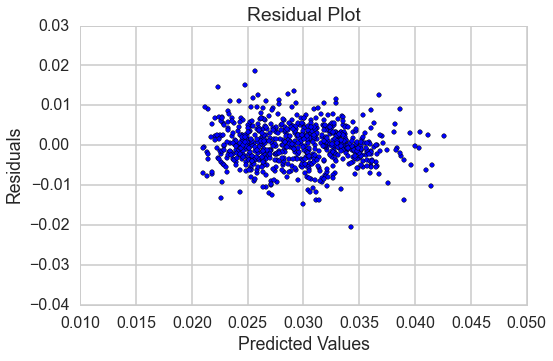

In [48]:
#Residual Plot
fig = plt.subplots(figsize=(8,5))
plt.scatter(res2.predict(ozone_gee_dat[['OZONE','Pressure','Wind','Precip','Temp','popdense2010','season','CBSA Name']]),
         ozone_gee_dat['OZONE'] - res2.predict(ozone_gee_dat[['OZONE','Pressure','Wind','Precip','Temp','popdense2010','season','CBSA Name']]))
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Residuals for this plot look like a random cloud so the assumption appears to be met.

#Summary

In summary, we have seen several things in this notebook:
1. In terms of predictive modeling, we are not able to achieve great results as $R^2$ and RMSE values are generally large.
2. The predictive models we do build do not generalize well to the French data, although some of the weaker predictor models may be extendable.
3. We have begun to develop models that indicate the relative contribution of anthropogenic and environmental variables to various air pollutants. More specifically, we've looked at $NO_2$ and ozone and showed the relative contribution of factors may differ between pollutants.

**Future steps:**<br>
Our model fit in general is not great but does yield some predictive power. In the future, it would be interesting to find more predictive variables -- this could include things about land use (agricultural vs. industrial vs. commercial), government air quality regulations, and more weather variables. Futhermore, it would be interesting to expand the dataset beyond just 2010. In order to better validate data, finding transportation data for a validation set that is more comparable to the US data would also be of great use. One final step would be to look beyond urban areas and try to capture information from more rural communities (less data for this) as well as looking at smaller areas of effect (individual towns) as pollutants can be quite localized in some cases.

####Image sources for presentation

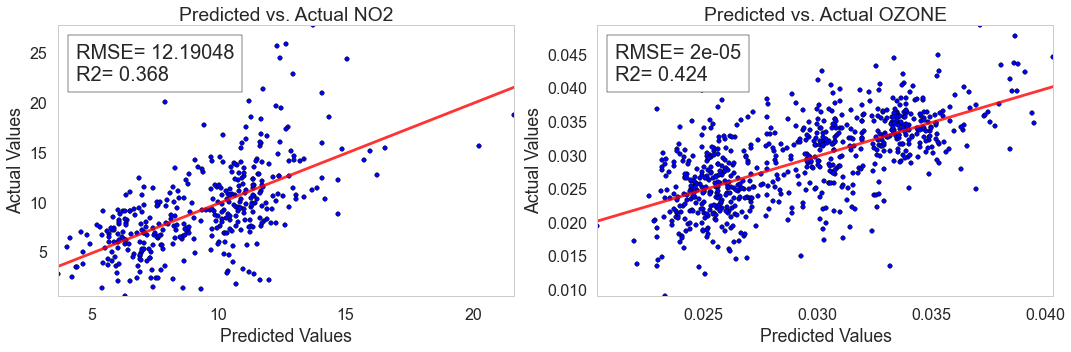

In [49]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
models_to_loop=[('NO2',no2_model_s,no2US_s),('OZONE',ozone_model_s,ozoneUS_s)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.set_tight_layout(True)

count = 0
for ax,j in zip(axes.ravel(),models_to_loop):
    ax.scatter(j[1].predict(),j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]])
    ax.plot([0,25], [0,25],color='r',alpha=.8)
    ax.set_ylim((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).min(),(j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).max())
    ax.set_xlim(j[1].predict().min(),j[1].predict().max())
    ax.set_ylabel('Actual Values')
    ax.set_xlabel('Predicted Values')
    ax.set_title('Predicted vs. Actual '+j[0])
    at = AnchoredText('RMSE= '+str(round(np.mean((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]] - j[1].predict()) ** 2),5))+'\nR2= '+str(round(j[1].rsquared,3)),
                  prop=dict(size=20), frameon=True,
                  loc=2)
    ax.grid(False)
    ax.add_artist(at)
